In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
y=pd.read_csv("../merge/merged_y.csv")
y.head()

,default
0,0
1,1
2,0
3,0
4,0


In [3]:
X=pd.read_csv("../merge/merged_x.csv")
X.head()

,loan_type,loan_amount,loan_term,interest_rate,loan_purpose,loan_to_value_ratio,origination_channel,age,annual_income,employment_length,...,existing_monthly_debt,monthly_payment,debt_service_ratio,payment_to_income_ratio,credit_utilization,available_credit,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow
0,2,17700.0,36,12.50,0,0.000,2,41,61800.0,2.2,...,738.64,592.13,0.258402,0.115,0.841,26886.9,15969.24,0.286408,159913.1,3819.230000
1,1,114000.0,180,6.83,6,0.774,0,38,28600.0,7.0,...,392.21,1013.86,0.589959,0.425,0.971,2267.8,16872.84,3.986014,189932.2,977.260000
2,2,9300.0,36,13.99,3,0.000,3,18,20700.0,0.8,...,204.07,317.81,0.302539,0.184,0.539,19085.4,6262.56,0.449275,31614.6,1203.120000
3,2,8700.0,48,13.26,4,0.000,3,27,31400.0,4.8,...,288.71,234.52,0.199961,0.090,0.147,51180.0,6278.76,0.277070,17520.0,2093.436667
4,2,7200.0,24,10.77,0,0.000,0,26,24600.0,5.2,...,248.77,334.81,0.284673,0.163,0.488,25446.4,7002.96,0.292683,31453.6,1466.420000


In [4]:
def train_balanced_model(X_train, y_train, weight_ratio=20):
    """
    Class weight bilan modelni o'rgatish
    weight_ratio: Class 1 ning Class 0 ga nisbati (default: 20)
    """
    

    class_weights = {
        0: 1,             
        1: weight_ratio    
    }
    
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight=class_weights,  
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    return model

def find_optimal_threshold(model, X_val, y_val, cost_fn=10, cost_fp=1):
    """
    Optimal threshold topish (biznes xarajatlarini hisobga olgan holda)
    cost_fn: False Negative xarajati (yomon mijozga kredit berish)
    cost_fp: False Positive xarajati (yaxshi mijozga rad etish)
    """
    
    y_proba = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    costs = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        total_cost = (fn * cost_fn) + (fp * cost_fp)
        costs.append(total_cost)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    
    f1_optimal_idx = np.argmax(f1_scores)
    f1_optimal_threshold = thresholds[f1_optimal_idx]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(thresholds, costs, 'b-', linewidth=2)
    ax1.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.3f}')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost ($)')
    ax1.set_title('Business Cost vs Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(thresholds, f1_scores, 'g-', linewidth=2)
    ax2.axvline(f1_optimal_threshold, color='r', linestyle='--', label=f'Optimal: {f1_optimal_threshold:.3f}')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('F1-Score vs Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_threshold, f1_optimal_threshold
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Modelni batafsil baholash
    """
    # Bashoratlar
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # Metrikalar
    print("="*60)
    print(f"THRESHOLD: {threshold:.3f}")
    print("="*60)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Class 0 (OK)', 'Class 1 (Reject)']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nConfusion Matrix:")
    print(f"True Negatives (TN):  {tn:6d} - To'g'ri rad etildi")
    print(f"False Positives (FP): {fp:6d} - Yaxshi mijoz rad etildi (Yo'qotilgan foyda)")
    print(f"False Negatives (FN): {fn:6d} - Yomon mijozga kredit berildi (KATTA ZARAR!) 🚨")
    print(f"True Positives (TP):  {tp:6d} - To'g'ri rad etildi")
    
    
    cost_fn = 10000  
    cost_fp = 500    
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    
    print("\n" + "="*60)
    print("BIZNES TA'SIRI:")
    print("="*60)
    print(f"False Negative xarajati: ${fn * cost_fn:,} ({fn} ta × ${cost_fn:,})")
    print(f"False Positive xarajati: ${fp * cost_fp:,} ({fp} ta × ${cost_fp:,})")
    print(f"UMUMIY XARAJAT:         ${total_cost:,}")
    print("="*60)
    
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix (Threshold = {threshold:.3f})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return {
        'accuracy': (tn + tp) / (tn + fp + fn + tp),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'roc_auc': roc_auc,
        'total_cost': total_cost,
        'fn_count': fn,
        'fp_count': fp
    }


Model o'rgatilmoqda...


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Optimal threshold topilmoqda...


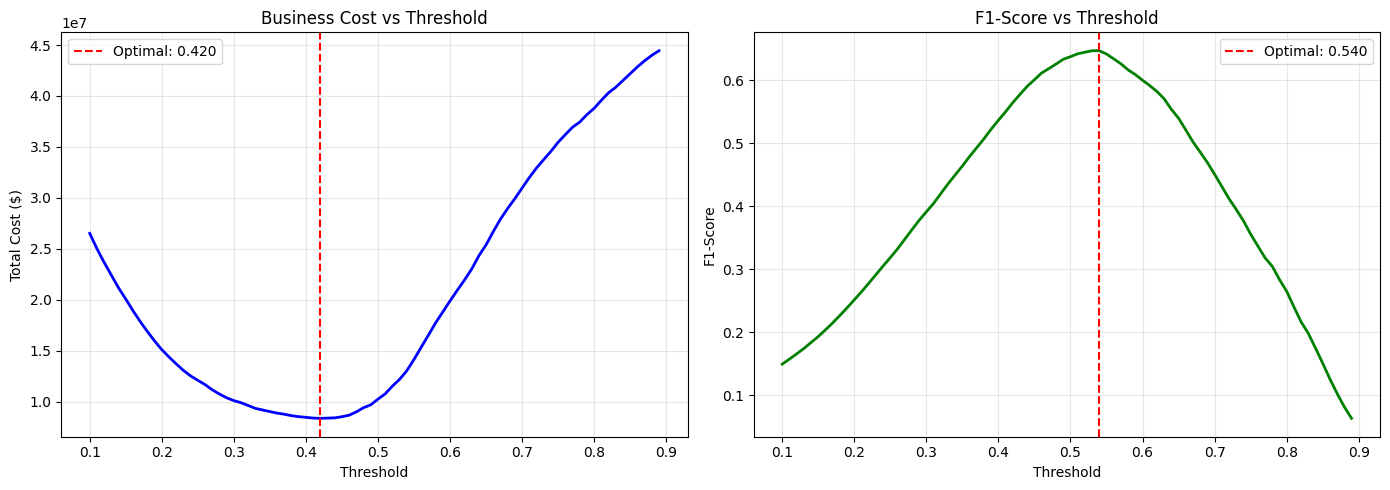



### DEFAULT THRESHOLD (0.5) ###
THRESHOLD: 0.500

Classification Report:
                  precision    recall  f1-score   support

    Class 0 (OK)       0.96      0.95      0.96     17081
Class 1 (Reject)       0.26      0.31      0.28       919

        accuracy                           0.92     18000
       macro avg       0.61      0.63      0.62     18000
    weighted avg       0.93      0.92      0.92     18000


Confusion Matrix:
True Negatives (TN):   16242 - To'g'ri rad etildi
False Positives (FP):    839 - Yaxshi mijoz rad etildi (Yo'qotilgan foyda)
False Negatives (FN):    630 - Yomon mijozga kredit berildi (KATTA ZARAR!) 🚨
True Positives (TP):     289 - To'g'ri rad etildi

BIZNES TA'SIRI:
False Negative xarajati: $6,300,000 (630 ta × $10,000)
False Positive xarajati: $419,500 (839 ta × $500)
UMUMIY XARAJAT:         $6,719,500

ROC-AUC Score: 0.7807


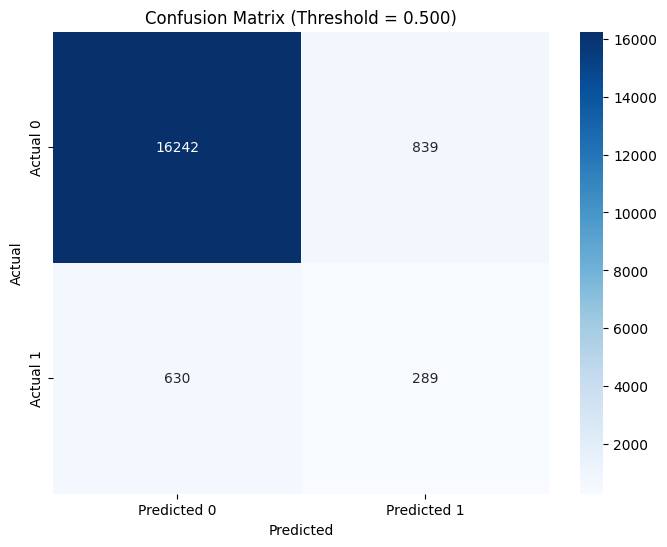



### OPTIMAL THRESHOLD ###
THRESHOLD: 0.420

Classification Report:
                  precision    recall  f1-score   support

    Class 0 (OK)       0.97      0.92      0.94     17081
Class 1 (Reject)       0.22      0.41      0.28       919

        accuracy                           0.89     18000
       macro avg       0.59      0.67      0.61     18000
    weighted avg       0.93      0.89      0.91     18000


Confusion Matrix:
True Negatives (TN):   15695 - To'g'ri rad etildi
False Positives (FP):   1386 - Yaxshi mijoz rad etildi (Yo'qotilgan foyda)
False Negatives (FN):    539 - Yomon mijozga kredit berildi (KATTA ZARAR!) 🚨
True Positives (TP):     380 - To'g'ri rad etildi

BIZNES TA'SIRI:
False Negative xarajati: $5,390,000 (539 ta × $10,000)
False Positive xarajati: $693,000 (1386 ta × $500)
UMUMIY XARAJAT:         $6,083,000

ROC-AUC Score: 0.7807


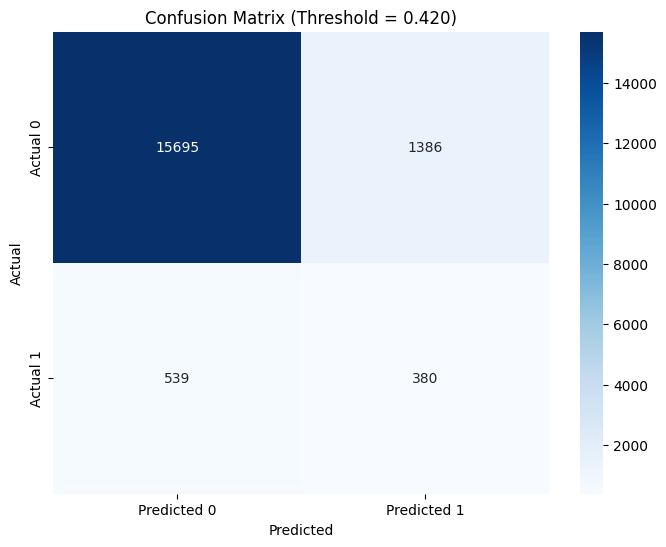

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Model o'rgatilmoqda...")
model = train_balanced_model(X_train, y_train, weight_ratio=20)


print("\nOptimal threshold topilmoqda...")
optimal_threshold, f1_threshold = find_optimal_threshold(model, X, y, cost_fn=10000, cost_fp=500)


print("\n\n### DEFAULT THRESHOLD (0.5) ###")
metrics_default = evaluate_model(model, X_test, y_test, threshold=0.5)


print("\n\n### OPTIMAL THRESHOLD ###")
metrics_optimal = evaluate_model(model, X_test, y_test, threshold=optimal_threshold)

def compare_results(metrics_before, metrics_after):
    """
    Eski va yangi natijalarni taqqoslash
    """
    print("\n" + "="*70)
    print("TAQQOSLASH: ESKI vs YANGI MODEL")
    print("="*70)
    
    comparison = {
        'Metric': ['Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)', 
                   'ROC-AUC', 'False Negatives', 'Total Cost'],
        'Eski Model': [0.15, 0.54, 0.24, 0.76, 423, '$4,230,000'],
        'Yangi Model': [
            f"{metrics_after['precision']:.2f}",
            f"{metrics_after['recall']:.2f}",
            f"{metrics_after['f1']:.2f}",
            f"{metrics_after['roc_auc']:.2f}",
            metrics_after['fn_count'],
            f"${metrics_after['total_cost']:,}"
        ]
    }
    
    df_comparison = pd.DataFrame(comparison)
    print(df_comparison.to_string(index=False))
    print("="*70)